# Spectral Indices
We have a selection of spectral indices available in FarmVibes.AI. This notebook demonstrates how to compute some of these indices on top of Sentinel-2 imagery using a user-defined workflow.

### Conda environment setup
To install the required packages, see [this README file](../README.md).

------------------------

In [1]:
import sys
from datetime import datetime

import matplotlib.pyplot as plt
import yaml
from shapely import geometry as shpg

from vibe_core.client import get_default_vibe_client

# Add shared notebook library to path
sys.path.append("../")
from shared_nb_lib.plot import lw_plot
from shared_nb_lib.raster import read_clip_index, read_raster, s2_to_img

In [2]:
client = get_default_vibe_client()

## Index computation workflow
One of the available data processing workflows is `data_processing/index/index`. It can be used as a task to compute an index given a raster. The index that will be computed by the workflow can be configured with the `index` parameter.

In [3]:
client.document_workflow("data_processing/index/index")

Workflow: data_processing/index/index

Description:

Computes an index from the bands of an input raster. In addition to the indices 'ndvi', 'evi',  
    'msavi', 'ndre', 'reci', 'ndmi', 'methane' and 'pri' all indices in                             
    https://github.com/awesome-spectral-indices/awesome-spectral-indices are available (depending on
    the bands available on the corresponding satellite product).

Sources:

- raster (vibe_core.data.rasters.Raster): Input raster.

Sinks:

- index_raster (vibe_core.data.rasters.Raster): Single-band raster with the computed index.

Parameters:

- index (default: ndvi): The choice of index to be computed ('ndvi', 'evi', 'msavi', 'ndre',    
    'reci', 'ndmi', 'methane', 'pri' or any of the awesome-spectral-indices).

Tasks:

- compute_index: Computes `index` over the input raster.

In this example, we will compute `ndvi`, `evi`, `ndmi`, `ndre`, `reci`, `ndwi`, and `lswi`. However, all indices in [awesome-spectral-indices](https://github.com/awesome-spectral-indices/awesome-spectral-indices) are also available (depending on the bands available on the corresponding satellite product).


We'll define a custom workflow that uses several tasks to compute the indices in parallel. The custom workflow, defined in `indices.yaml`, is shown below:

In [4]:
# Sample custom workflow that uses a data ingestion workflow to download Sentinel-2 data
# and then computes several indices on the available imagery
!cat indices.yaml

name: indices
sources:
  user_input:
    - s2.user_input
sinks:
  s2: s2.raster
  ndvi: ndvi.index_raster
  evi: evi.index_raster
  ndmi: ndmi.index_raster
  ndre: ndre.index_raster
  reci: reci.index_raster
  ndwi: ndwi.index_raster
  lswi: lswi.index_raster
parameters:
  pc_key:
tasks:
  s2:
    workflow: data_ingestion/sentinel2/preprocess_s2
    parameters:
      pc_key: "@from(pc_key)"
  ndvi:
    workflow: data_processing/index/index
    parameters:
      index: ndvi
  evi:
    workflow: data_processing/index/index
    parameters:
      index: evi
  ndmi:
    workflow: data_processing/index/index
    parameters:
      index: ndmi
  ndre:
    workflow: data_processing/index/index
    parameters:
      index: ndre
  reci:
    workflow: data_processing/index/index
    parameters:
      index: reci
  ndwi:
    workflow: data_processing/index/index
    parameters:
      index: NDWI
  lswi:
    workflow: data_processing/index/index
    parameters:
      index: LSWI
edges:
  - origin: s

## Submiting custom workflows
We can submit a custom workflow by loading its definition into a dictionary and using that instead of the name of a built-in workflow.

In [5]:
# Load our workflow definition in the YAML file into a dict
with open("indices.yaml") as f:
    wf_dict = yaml.safe_load(f)

# Define our workflow inputs.
geom = shpg.Point(-119.21896203939313, 46.44578909859286).buffer(.05, cap_style=3)
time_range = (datetime(2020, 5, 1), datetime(2020, 5, 5))

In [6]:
# Submit a run request by sending the worflow dictionary
run = client.run(wf_dict, "Spectral indices", geometry=geom, time_range=time_range)
run.monitor()

Output()

## Workflow outputs
We defined several outputs in the workflow definition. The sink `s2` contains the original Sentinel-2 imagery, while the others contain the spectral indices computed on top of it. Let's see what they look like

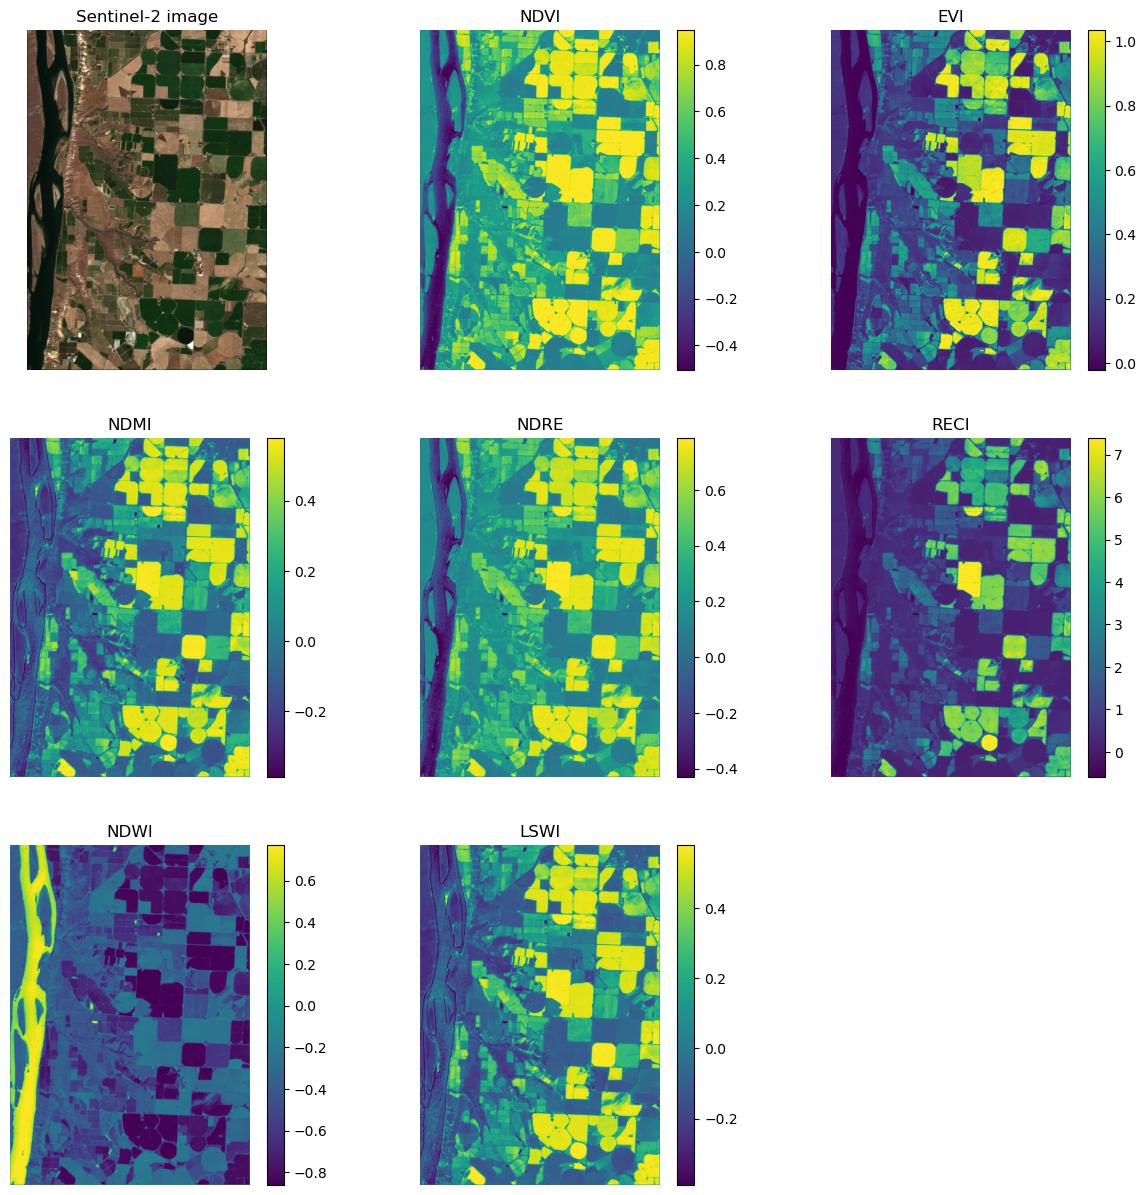

In [7]:
plt.figure(figsize=(15, 15))
# Read and plot the Sentinel-2 imagery
plt.subplot(3, 3, 1)
plt.imshow(s2_to_img(read_raster(run.output["s2"][0], geom)[0]))
plt.title("Sentinel-2 image")
plt.axis("off")

# Read and plot each of the indices=
for i, k in enumerate([k for k in run.output if k != "s2"], start=2):
    plt.subplot(3, 3, i)
    plt.imshow(read_clip_index(run.output[k][0], geom))
    plt.axis("off")
    plt.colorbar()
    plt.title(k.upper())
lw_plot()